# Classification

# MNIST

First, we fetch the MNIST dataset from Scikit-Learn

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Scikit-Learn generally have similar dictionary structure including:

-> DESCR key describing dataset

-> data key containing an array with one row per instance and one column per feature

-> target key containing an array with labels

In [2]:
x,y = mnist["data"],mnist["target"]
x.shape


(70000, 784)

Here, images = 7000 and features = 784  (28x28 pixels)


In [3]:
y.shape

(70000,)

reshaping instance's feature vector into 28x28 array and displaying it
using Matplotlib’s imshow() function

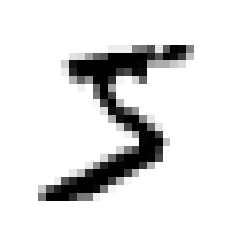

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = x[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

it looks line 5 and label tells the same

In [5]:
y[0]

'5'

casting y to integer  

uint8  
u-> unsigned(all values are positive)  
int-> integers  
8->only 8 bits of information(0-255)

In [6]:
import numpy as np
y = y.astype(np.uint8)


first 6000 images->training set    
last 1000 images->test set

In [7]:
x_train, x_test, y_train, y_test = x[:6000], x[6000:], y[:6000], y[6000:]

# Training a Binary Classifier

Taking "5-detector" as an example of a binary classifier, capable of
distinguishing between just two classes, 5 and not-5.

In [8]:
y_train_5 = (y_train==5) #True for all 5s, False for all other digits
y_test_5 = (y_test==5)

training SGDClassifier on the whole training set   
SGD-> Stochastic Gradient Descent

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(x_train,y_train_5)

SGDClassifier(random_state=42)

now, using it to detect images of the number 5

In [10]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures    

### Measuring Accuracy Using Cross-Validation



In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.962 , 0.956 , 0.9665])

Above, there is above 95% accuracy on all cross-validation folds.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, x, y=None):
        return self
    def predict(self,x):
        return np.zeros((len(x),1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, x_train, y_train_5, cv=3, scoring="accuracy")

array([0.91 , 0.915, 0.918])

Whereas, for "not-5" class there is above 91% accuracy simply because about 9% of the images are 5s.  
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others).


### Confusion Matrix

_General idea_: To count the no of times instances of class A are classified as B, eg to know the no of times the classifier confused images of 5s with 3s, we should look in the 5th row and 3rd column of the confusion matrix.   

To compute the confusion matrix, first we need to have a set of predictions so that they can be compared to the actual targets.

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3)

cross_val_predict performs K-fold and returns the predictions made on each test fold unlike cross_val_score that returns evaluation score.




Below, y_train_5 = target classes                            
       y_train_pred = predicted classes

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[5375,  111],
       [ 120,  394]], dtype=int64)

each row = actual class and each column= predicted class 

__1st row considers non-5s images (negative class)__: 5375 of them were correctly classified as non-5s (true negative) and remaining 111 were wrongly classified as 5s (false positive).   

__2nd row considers 5s images (positive class)__: 120 of them were wrongly classified as non-5s (false negative) and remaining 394 were correctly classified as 5s (true positive).   

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [16]:
y_train_perfect_predictions = y_train_5 #pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[5486,    0],
       [   0,  514]], dtype=int64)

### Precision and Recall

__Precision__: Accuracy of the positive predictions    
              precision= TP / (TP+FP)


In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)  # == 394 / (394+111)


0.7801980198019802

__Recall__: Ration of positive instances that are correctly detected by classifier. Also called _sesitivity_ or _true positive rate (TPR)_.    
recall= TP / (TP+FN) 

In [18]:
recall_score(y_train_5, y_train_pred)  # == 394 / (394+120)

0.7665369649805448

The above result shows that when an image represents 5, it is correct only 78.01% of the time but it detects 76.65% of the 5s.  

In order to compare these two classifiers, we combine precision and recall into a single metric called _F1 score_.  
F1 scoreis the harmonic mean of precision and recall which gives much more weight to low values unlike regular mean (treats all value equally). As a result, the classifier will only get a high F1 score if both recall and precision are high.     

F1 = 2 / (1/precision) + (1/recall)  
  = 2 * (precision * recall) / (precision + recall)  
 = TP / (TP + ((FN+FP)/2) )

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7733071638861628

The F1 score favors classifiers that have similar precision and recall.  

### Precision/Recall Trade-off
increasing precision reduces recall, and vice versa

In [20]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([38042.34312442])

In [21]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [22]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [23]:
y_scores = cross_val_predict(sgd_clf, x_train, y_train_5, cv=3, method="decision_function")

In [24]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

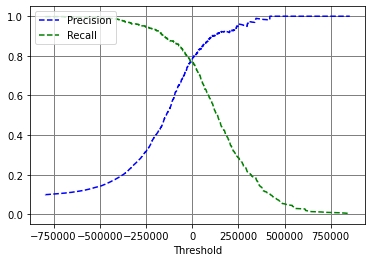

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1],"g--", label="Recall")
    plt.xlabel("Threshold")
    plt.grid(axis="both", color='gray', linestyle='-', linewidth=1)
    plt.legend(loc='upper left')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [26]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]  # ~7816

In [27]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [28]:
precision_score(y_train_5, y_train_pred_90)

0.9012345679012346

In [29]:
recall_score(y_train_5, y_train_pred_90)

0.5680933852140078

90% precision at 56% recall

### The ROC Curve
ROC-> receiver operating characteristic   
It plots true positive rate (recall) vs false positive rate (FPR)

In [30]:
from sklearn.metrics import roc_curve

fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

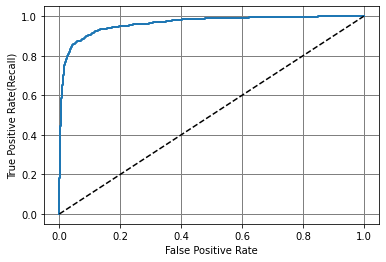

In [31]:
def plot_roc_curve (fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0, 1], 'k--')  # Dashed diagonal
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate(Recall)")
    plt.grid(axis="both",color="gray",linewidth=1)
plot_roc_curve(fpr,tpr)
plt.show()

In [32]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5,y_scores)

0.9641599203348885

In [33]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, x_train, y_train_5, cv=3, method="predict_proba")

In [34]:
y_scores_forest = y_probas_forest[:,1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

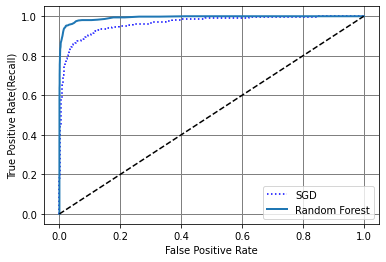

In [35]:
plt.plot(fpr,tpr,"b:",label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [36]:
roc_auc_score(y_train_5, y_scores_forest)

0.9936162229715256

# Multiclass Classification

__OvR (one versus the rest, also known as one versus all)__: It trains 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). While classifying the image, we get the decision score from each classifier for that image and then we select the class whose classifier outputs the highest score.   

__OvO (one versus one)__: It trains a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. If there are N classes, we need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers.  
The main advantage of OvO is that each classifier only needs to be trained on the part of the training set for the two classes that it must distinguish.  

_Scikit-Learn_ automatically runs OvR or OvO depending on the algorithm when we use binary classification algorithm for a multiclass classification task.

In [37]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(x_train, y_train) # y_train, not y_train_
svm_clf.predict([some_digit])

array([5], dtype=uint8)

Above, it uses OvO strategy: it trained 45 binary classifiers, got their decision scores for the image, and selected the class that won the most duels.

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.74201669,  3.75934047,  6.18134457,  8.29644372, -0.30252035,
         9.30527336,  1.74930094,  2.77838477,  7.19221016,  3.87315474]])

Here, it returns 10 scores per instance (instead of just 1).

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [41]:
svm_clf.classes_[5]

5

If we want to force Scikit-Learn to use OvO or OvR then we can use _OneVsOneClassifier_ or _OneVsRestClassifier_. 
Creatinf multiclass classifier using OvR strategy, bases on SVC.

In [42]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(x_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
len(ovr_clf.estimators_)

10

In [44]:
sgd_clf.fit(x_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [45]:
sgd_clf.decision_function([some_digit])

array([[-735711.69660953, -857058.38635209, -281086.00104909,
           8289.73273042, -616793.26669143,   29040.2961313 ,
        -492305.02284074, -834395.17091855, -318385.3774766 ,
        -363474.38706356]])

In [46]:
cross_val_score(sgd_clf, x_train, y_train, cv=3, scoring="accuracy")

array([0.8565, 0.8715, 0.8635])

In [47]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float64))
cross_val_score(sgd_clf, x_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8705, 0.8985, 0.8925])

# Error Analysis

In [48]:
y_train_pred = cross_val_predict(sgd_clf, x_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[572,   0,   1,   2,   1,   9,   3,   1,   3,   0],
       [  0, 637,   6,   3,   1,   5,   0,   1,  16,   2],
       [ 10,  12, 493,  11,  10,   4,  10,   9,  20,   2],
       [  3,   5,  21, 514,   1,  35,   1,   7,  11,  10],
       [  3,   2,   7,   0, 556,   2,  10,   8,   9,  26],
       [  5,   6,   5,  24,  14, 411,  10,   1,  25,  13],
       [  4,   4,   6,   0,   5,   6, 577,   1,   5,   0],
       [  3,   4,   7,   2,   9,   0,   1, 577,   3,  45],
       [  2,  19,  13,  16,   4,  10,   6,   3, 464,  14],
       [  7,   4,   5,   7,  15,   3,   0,  27,  11, 522]], dtype=int64)

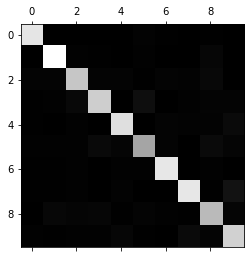

In [49]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [50]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

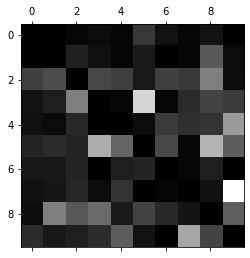

In [51]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

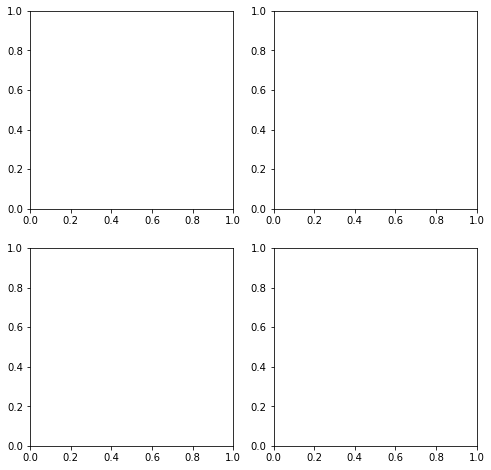

In [52]:
cl_a, cl_b = 3, 5
x_aa = x_train[(y_train == cl_a) & (y_train_pred == cl_a)]
x_ab = x_train[(y_train == cl_a) & (y_train_pred == cl_b)]
x_ba = x_train[(y_train == cl_b) & (y_train_pred == cl_a)]
x_bb = x_train[(y_train == cl_b) & (y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221)
#plot_digits(x_aa[:25], images_per_row=5);

plt.subplot(222)
#plot_digits(x_ab[:25], images_per_row=5)

plt.subplot(223) 
#plot_digits(x_ba[:25], images_per_row=5)

plt.subplot(224) 
#plot_digits(x_bb[:25], images_per_row=5)
plt.show()


# Multilabel Classification
classification system that outputs multiple binary tags

In [53]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(x_train, y_multilabel)

KNeighborsClassifier()

In [54]:
knn_clf.predict([some_digit])

array([[False,  True]])

False because 5<7 and True because 5 is odd number

In [55]:
y_train_knn_pred = cross_val_predict(knn_clf, x_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.9500922726736858

If we want to give more weight to the classifier's score then set average="weighted"

# Multioutput Classification
generalization of multilabel classification where each label can be multiclass

Adding noise to the pixel intensities with NumPy’s randint() function. The target images will be the original images

In [56]:
noise = np.random.randint(0,100,(len(x_train),784))
x_train_mod = x_train + noise
noise = np.random.randint(0,100,(len(x_test),784))
x_test_mod = x_test + noise
y_train_mod = x_train
y_test_mod = x_test

Training classifier to make the image clean

In [57]:
knn_clf.fit(x_train_mod, y_train_mod)
clean_digit = knn_clf.predict([x_test_mod[some_index]])
plot_digit(clean_digit)

NameError: name 'some_index' is not defined